In [154]:
# Data libraries.
import numpy as np
import pandas as pd

# Data vizualization libraries.
from tqdm import tqdm
import matplotlib.pyplot as plt

# Association rules libraries.
from efficient_apriori import apriori

# Machine learning libraries.
import datawig

# Utilities we wrote for this project.
import utils

## 1. Load Dataset

In [126]:
# Read data from files.
df = pd.read_csv('./data/adultsIncome/raw/adultsIncome_sampled_no_nan.csv')
df_with_missing = pd.read_csv('./data/adultsIncome/10percent/adultsIncome_sampled_0.1_nan.csv')
df_with_missing_ar = df_with_missing.copy(deep=True)
df_with_missing_ml = df_with_missing.copy(deep=True)
df_with_missing

,age,workclass,observation-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,30.0,Private,202450.0,HS-grad,9.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,65.0,United-States,>50K
1,40.0,Private,217120.0,10th,6.0,Divorced,Craft-repair,Not-in-family,White,Male,0.0,NaN,50.0,United-States,<=50K
2,NaN,Private,240398.0,Bachelors,13.0,Never-married,Sales,Not-in-family,Black,Male,0.0,0.0,NaN,United-States,<=50K
3,47.0,State-gov,100818.0,NaN,9.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,United-States,>50K
4,43.0,Private,191814.0,Assoc-acdm,12.0,Married-civ-spouse,Sales,Husband,White,Male,7688.0,NaN,50.0,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,41.0,NaN,145441.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,50.0,United-States,>50K
1496,31.0,Private,74501.0,HS-grad,9.0,NaN,Other-service,Unmarried,NaN,Female,0.0,0.0,30.0,NaN,NaN
1497,47.0,Private,175958.0,Prof-school,NaN,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
1498,30.0,Private,149368.0,HS-grad,9.0,Divorced,Sales,Unmarried,White,Male,NaN,0.0,30.0,United-States,<=50K


In [127]:
num_of_missing_before = df_with_missing_ar.isnull().sum().sum()
print(f'Number of missing values: {num_of_missing_before}')

Number of missing values: 2265


## Association Rules algorithm to fill missing values

In [128]:
df_for_apriori = df_with_missing_ar.copy(deep=True)

# go through each column and replace the values with a string
for col in df_for_apriori.columns:
    df_for_apriori[col] = df_for_apriori[col].astype(str)
# convert the dataframe to a list of lists
dict_for_apriori = df_for_apriori.to_dict(orient='records')
transactions = [list(item.items()) for item in dict_for_apriori]

Finding the association rules using the Apriori algorithm

In [129]:
itemsets, rules = apriori(transactions, min_support=0.3, min_confidence=0.6, output_transaction_ids=False)
rules = [rule for rule in rules if not any(map(lambda x: x[1] == 'nan', rule.rhs)) and not any(map(lambda x: x[1] == 'nan', rule.lhs))]
print(f'We have {len(rules)} rules and here are the first 10:')
rules[:10]

We have 319 rules and here are the first 10:


[{('capital-loss', '0.0')} -> {('capital-gain', '0.0')},
 {('capital-gain', '0.0')} -> {('capital-loss', '0.0')},
 {('class', '<=50K')} -> {('capital-gain', '0.0')},
 {('capital-gain', '0.0')} -> {('class', '<=50K')},
 {('hours-per-week', '40.0')} -> {('capital-gain', '0.0')},
 {('marital-status', 'Married-civ-spouse')} -> {('capital-gain', '0.0')},
 {('native-country', 'United-States')} -> {('capital-gain', '0.0')},
 {('capital-gain', '0.0')} -> {('native-country', 'United-States')},
 {('race', 'White')} -> {('capital-gain', '0.0')},
 {('capital-gain', '0.0')} -> {('race', 'White')}]

In [130]:
# sort rules by lift value
sorted_rules = sorted(rules, key=lambda x: x.lift, reverse=True)
for rule in sorted_rules[:10]:
    print(f'Rule: {rule.lhs} -> {rule.rhs}, Lift: {rule.lift}')

Rule: (('marital-status', 'Married-civ-spouse'), ('sex', 'Male')) -> (('relationship', 'Husband'),), Lift: 2.4184048951850814
Rule: (('relationship', 'Husband'),) -> (('marital-status', 'Married-civ-spouse'), ('sex', 'Male')), Lift: 2.4184048951850814
Rule: (('relationship', 'Husband'),) -> (('marital-status', 'Married-civ-spouse'),), Lift: 2.186875331021168
Rule: (('marital-status', 'Married-civ-spouse'),) -> (('relationship', 'Husband'),), Lift: 2.186875331021168
Rule: (('relationship', 'Husband'), ('sex', 'Male')) -> (('marital-status', 'Married-civ-spouse'),), Lift: 2.1843243345029095
Rule: (('marital-status', 'Married-civ-spouse'),) -> (('relationship', 'Husband'), ('sex', 'Male')), Lift: 2.1843243345029095
Rule: (('relationship', 'Husband'),) -> (('sex', 'Male'),), Lift: 1.435614521988312
Rule: (('marital-status', 'Married-civ-spouse'), ('relationship', 'Husband')) -> (('sex', 'Male'),), Lift: 1.4339398734177216
Rule: (('marital-status', 'Married-civ-spouse'),) -> (('sex', 'Male'

In [131]:
df_missing_index_rows = df_with_missing_ar.index[df_with_missing_ar.isna().any(axis=1)]

### Fill missing values algorithm

In [132]:
# create a dictionary with the column names and the index of the column
col_names_dict = {}
for i, col in enumerate(df_with_missing_ar.columns):
    col_names_dict[col] = i

In [133]:
# algortihm to fill missing values
for index in tqdm(df_missing_index_rows):
    # print the current row on the same line (replacing the previous line)
    row = df_with_missing_ar.iloc[index]
    rhs, lhs = [], []

    for col in row.index:
        rhs.append(col) if row[col] != row[col] else lhs.append(col)

    relevant_rules = []
    for rule in sorted_rules:
        # check if [col[0] for col in rule.rhs] is a subset of rhs
        if set([col[0] for col in rule.rhs]).issubset(set(rhs)): relevant_rules.append(rule)

    for rule in relevant_rules:
        # check if [keyval[0] for keyval in rule.lhs] is a subset of lhs
        if set([keyval for keyval in rule.lhs]).issubset(set([(col, row[col]) for col in lhs])):
            should_fill = True
            for keyval in rule.rhs:
                if row[keyval[0]] == row[keyval[0]] and keyval[1] != row[keyval[0]]:
                    should_fill = False
                    break
            if should_fill:
                for keyval in rule.rhs:
                    df_with_missing_ar.iloc[index, col_names_dict[keyval[0]]] = pd.to_numeric(keyval[1], errors='ignore')

df_with_missing_ar

100%|██████████| 1196/1196 [00:04<00:00, 280.01it/s]


,age,workclass,observation-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,30.0,Private,202450.0,HS-grad,9.0,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,65.0,United-States,>50K
1,40.0,Private,217120.0,10th,6.0,Divorced,Craft-repair,Not-in-family,White,Male,0.0,0.0,50.0,United-States,<=50K
2,NaN,Private,240398.0,Bachelors,13.0,Never-married,Sales,Not-in-family,Black,Male,0.0,0.0,NaN,United-States,<=50K
3,47.0,State-gov,100818.0,NaN,9.0,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40.0,United-States,>50K
4,43.0,Private,191814.0,Assoc-acdm,12.0,Married-civ-spouse,Sales,Husband,White,Male,7688.0,0.0,50.0,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,41.0,Private,145441.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,50.0,United-States,>50K
1496,31.0,Private,74501.0,HS-grad,9.0,NaN,Other-service,Unmarried,White,Female,0.0,0.0,30.0,United-States,<=50K
1497,47.0,Private,175958.0,Prof-school,NaN,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
1498,30.0,Private,149368.0,HS-grad,9.0,Divorced,Sales,Unmarried,White,Male,0.0,0.0,30.0,United-States,<=50K


In [134]:
num_of_missing_after = df_with_missing_ar.isnull().sum().sum()
print(f'Number of filled values: {num_of_missing_before - num_of_missing_after}')
print(f'Number of left missing values: {num_of_missing_after}')

Number of filled values: 1172
Number of left missing values: 1093


In [135]:
# df_with_missing_ar = utils.pd.read_csv(f'./test.csv')
print(f'With NaN = {utils.check_accuracy(df,df_with_missing,df_with_missing_ar,True)}')
print(f'Without NaN = {utils.check_accuracy(df,df_with_missing,df_with_missing_ar,False)}')

Checking accuracy: 100%|██████████| 1500/1500 [00:00<00:00, 2678.37it/s]


With NaN = {'correct': 1001, 'total': 2265, 'accuracy': 44.19426}


Checking accuracy: 100%|██████████| 1500/1500 [00:00<00:00, 2618.33it/s]

Without NaN = {'correct': 1001, 'total': 1172, 'accuracy': 85.40956}


## Machine learning algorithm to fill missing values

In [136]:
# Map categorical colums to numerical ones.
df_for_datawig = df_with_missing.copy(deep=True)
cols = utils.create_map_from_data(df)
# replace in raw data
for col_name in cols:
    print(f'{col_name}: {cols[col_name]}')
    df_for_datawig.replace({col_name: cols[col_name]},inplace=True)
df_for_datawig

workclass: {'Private': 0, 'State-gov': 1, 'Self-emp-not-inc': 2, 'Local-gov': 3, 'Federal-gov': 4, 'Self-emp-inc': 5}
education: {'HS-grad': 0, '10th': 1, 'Bachelors': 2, 'Assoc-acdm': 3, 'Some-college': 4, 'Doctorate': 5, 'Prof-school': 6, '9th': 7, 'Assoc-voc': 8, 'Masters': 9, '7th-8th': 10, '11th': 11, '1st-4th': 12, '5th-6th': 13, '12th': 14, 'Preschool': 15}
marital-status: {'Married-civ-spouse': 0, 'Divorced': 1, 'Never-married': 2, 'Widowed': 3, 'Separated': 4, 'Married-spouse-absent': 5}
occupation: {'Transport-moving': 0, 'Craft-repair': 1, 'Sales': 2, 'Adm-clerical': 3, 'Prof-specialty': 4, 'Other-service': 5, 'Exec-managerial': 6, 'Farming-fishing': 7, 'Machine-op-inspct': 8, 'Handlers-cleaners': 9, 'Protective-serv': 10, 'Tech-support': 11, 'Priv-house-serv': 12}
relationship: {'Husband': 0, 'Not-in-family': 1, 'Wife': 2, 'Own-child': 3, 'Unmarried': 4, 'Other-relative': 5}
race: {'White': 0, 'Black': 1, 'Other': 2, 'Asian-Pac-Islander': 3, 'Amer-Indian-Eskimo': 4}
sex: {'

,age,workclass,observation-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,30.0,0.0,202450.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0
1,40.0,0.0,217120.0,1.0,6.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,50.0,0.0,1.0
2,NaN,0.0,240398.0,2.0,13.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0,1.0
3,47.0,1.0,100818.0,NaN,9.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,40.0,0.0,0.0
4,43.0,0.0,191814.0,3.0,12.0,0.0,2.0,0.0,0.0,0.0,7688.0,NaN,50.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,41.0,NaN,145441.0,9.0,14.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0
1496,31.0,0.0,74501.0,0.0,9.0,NaN,5.0,4.0,NaN,1.0,0.0,0.0,30.0,NaN,NaN
1497,47.0,0.0,175958.0,6.0,NaN,0.0,2.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0
1498,30.0,0.0,149368.0,0.0,9.0,1.0,2.0,4.0,0.0,0.0,NaN,0.0,30.0,0.0,1.0


In [137]:
# Impute missing values using datawig.
df_with_missing_ml = datawig.SimpleImputer.complete(df_for_datawig)

# check if the df_original is type int, if so, convert the df_with_missing_imputed to int
for col in df.columns:
    if df[col].dtype == 'int64' or df[col].dtype == 'object':
        df_with_missing_ml[col] = round(df_with_missing_ml[col]).astype(int)
cols_map = utils.create_map_from_data(df, reverse=True)
for col in cols_map:
    df_with_missing_ml.replace({col:cols_map[col]}, inplace=True)

In [138]:
print(f'With NaN = {utils.check_accuracy(df, df_with_missing, df_with_missing_ml, True)}')
print(f'Without NaN = {utils.check_accuracy(df, df_with_missing, df_with_missing_ml, False)}')

Checking accuracy: 100%|██████████| 1500/1500 [00:00<00:00, 2097.93it/s]


With NaN = {'correct': 712, 'total': 2265, 'accuracy': 31.43488}


Checking accuracy: 100%|██████████| 1500/1500 [00:00<00:00, 1995.00it/s]

Without NaN = {'correct': 712, 'total': 2265, 'accuracy': 31.43488}


## Compare the results

Checking accuracy: 100%|██████████| 1500/1500 [00:01<00:00, 1458.73it/s]


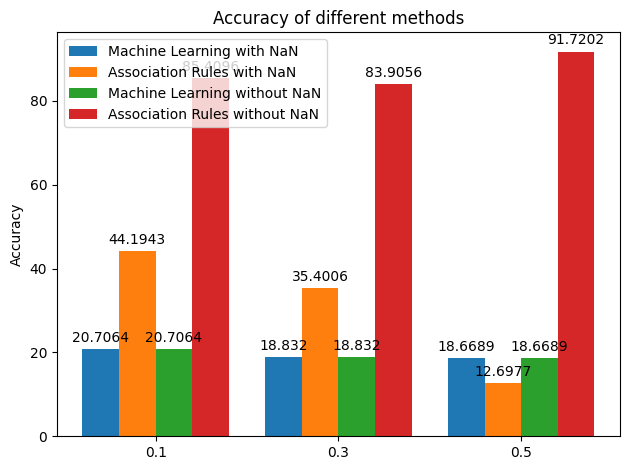

In [155]:
utils.print_graph_imputed_data('adultsIncome', True)